In [1]:
from ocr import OCR
from PIL import Image
import cv2
import os
import keras_ocr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob as glob
import openpyxl as op


2022-11-24 12:24:36.255201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 12:24:36.709333: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-24 12:24:36.741316: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/carlo/anaconda3/envs/eyes/lib/python3.10/site-packages/cv2/../../lib64:
2022-

# Dictionary crops

In [2]:
crops={
    'densities':{},
    'faz':{}
      }
crops['densities']['table_top']={
                                'l' : 1530,
                                't' : 154,
                                'r' : 1825,
                                'b' : 540
                                }
crops['densities']['table_bot']={
                                'l' : 1540,
                                't' : 565,
                                'r' : 1820,
                                'b' : 625
                                }
crops['densities']['quality']={
                                'l' : 1116,
                                't' : 55,
                                'r' : 1200,
                                'b' : 100
                                }
crops['faz']['values']={
                            'l' : 400,
                            't' : 90,
                            'r' : 800,
                            'b' : 120
                            }


crops['faz']['quality']={
                        'l' : 1116,
                        't' : 55,
                        'r' : 1200,
                        'b' : 100
                        }


# FILES

In [4]:
#first iteration
folders_patients=glob('../data/P*')
folders_visits=glob('../data/P*/V*')
visits=sorted(
    list(
        set([folder.split("/")[3] for folder in folders_visits])
    )
)
patients=sorted(
    list(
        set([folder.split('/')[2] for folder in folders_patients]) 
    )
)

#Calm down here
# imgs={}
# for patient in patients:
#     imgs[patient]={}
#     files=glob('../data/'+patient+"/*/*")
#     files=[file for file in files if 'Zone' not in file]
#     densities=[file for file in files if ('Density' in file) ]
#     fazs=[file for file in files if ('FAZ' in file)  ]
#     imgs[patient]['densities']=densities
#     imgs[patient]['fazs']=fazs


In [5]:
#second iteration
files=glob('../data/*/*/*png')
files=[file for file in files if 'QuickVue' not in file]

imgpervisit={}
for visit in visits:
    imgpervisit[visit]=sorted([file for file in files if visit in file])



In [6]:
imgpervisit['V2']

['../data/P001/V2/P001, L eye, V2, 3.0 - Density DP.png',
 '../data/P001/V2/P001, L eye, V2, 3.0 - Density SUP.png',
 '../data/P001/V2/P001, L eye, V2, 3.0 - FAZ.png',
 '../data/P001/V2/P001, L eye, V2, 6.0 - Density DP.png',
 '../data/P001/V2/P001, L eye, V2, 6.0 - Density SUP.png',
 '../data/P001/V2/P001, L eye, V2, 6.0 - FAZ.png',
 '../data/P001/V2/P001, R eye, V2, 3.0 - Density DP.png',
 '../data/P001/V2/P001, R eye, V2, 3.0 - Density SUP.png',
 '../data/P001/V2/P001, R eye, V2, 3.0 - FAZ.png',
 '../data/P001/V2/P001, R eye, V2, 6.0 - Density DP.png',
 '../data/P001/V2/P001, R eye, V2, 6.0 - Density SUP.png',
 '../data/P001/V2/P001, R eye, V2, 6.0 - FAZ.png',
 '../data/P002/V2/P002, L eye, V2, 3.0 - Density DP.png',
 '../data/P002/V2/P002, L eye, V2, 3.0 - Density SUP.png',
 '../data/P002/V2/P002, L eye, V2, 3.0 - FAZ.png',
 '../data/P002/V2/P002, R eye, V2, 3.0 - Density DP.png',
 '../data/P002/V2/P002, R eye, V2, 3.0 - Density SUP.png',
 '../data/P002/V2/P002, R eye, V2, 3.0 - FA

In [132]:
cols=[
 'QUALITY',
 'depth_whole',
 'depth_sup hemi',
 'depth_inf hemi',
 'depth_fovea',
 'depth_parafovea',
 'depth_para_sup hemi',
 'depth_parai_inf hemi',
 'depth_para temp',
 'depth_para_sup',
 'depth_para_nasal',
 'depth_para_inf',
 'depth_perifovea',
 'depth_peri_sup hemi',
 'depth_peri_inf hemi',
 'depth_peri_tempo ',
 'depth_peri_sup',
 'depth_peri_nasal',
 'depth_peri_inf',
 'thick_whole',
 'thick_sup hemi',
 'thick_inf hemi',
 'thick_fovea',
 'thick_parafovea',
 'thick_para_sup hemi',
 'thick_parai_inf hemi',
 'thick_para temp',
 'thick_para_sup',
 'thick_para_nasal',
 'thick_para_inf',
 'thick_perifovea',
 'thick_peri_sup hemi',
 'thick_peri_inf hemi',
 'thick_peri_tempo ',
 'thick_peri_sup',
 'thick_peri_nasal',
 'thick_peri_inf',
 'grid_v_d1',
 'grid_v_d2',
 'grid_v_d3',
 'grid_v_d4',
 'grid_v_d5',
 'grid_v_d6',
 'grid_v_d7',
 'grid_v_d8',
 'grid_v_d9',
 'area (mm2)',
 'perim (mm)',
 'FD']
df=pd.DataFrame(columns=['pat','v','eye','depth']+cols) # MAKE THE COLUMNS, cols come from readin the sheet.
for file in files[3:4]:
    print(file)
    pat=file.split('/')[2]
    v=file.split('/')[3]
    eye=file.split(',')[1].strip()
    depth=file.split(',')[3].split('-')[0].strip()
    fdelete = glob('evaluate/*')
    for f in fdelete:
        os.remove(f)
    if 'Density' in file:
        im = Image.open(file)
        cropped_top= im.crop((crops['densities']['table_top']['l'],
                              crops['densities']['table_top']['t'],
                              crops['densities']['table_top']['r'],
                              crops['densities']['table_top']['b']))
        cropped_bot= im.crop((crops['densities']['table_bot']['l'],
                              crops['densities']['table_bot']['t'],
                              crops['densities']['table_bot']['r'],
                              crops['densities']['table_bot']['b']))
        cropped_qual= im.crop((crops['densities']['quality']['l'],
                               crops['densities']['quality']['t'],
                               crops['densities']['quality']['r'],
                               crops['densities']['quality']['b']))
        cropped_top.save('evaluate/cropped_top.png')
        cropped_bot.save('evaluate/cropped_bot.png')
        cropped_qual.save('evaluate/cropped_quality.png')
        ocr=OCR(image_folder="evaluate/")
        results=ocr.easyocr_model_works(visualization=False)  
    elif 'FAZ' in file:
        im = Image.open(file)
        cropped_values= im.crop((crops['faz']['values']['l'],
                                 crops['faz']['values']['t'],
                                 crops['faz']['values']['r'],
                                 crops['faz']['values']['b']))

        cropped_qual= im.crop((crops['faz']['quality']['l'],
                               crops['faz']['quality']['t'],
                               crops['faz']['quality']['r'],
                               crops['faz']['quality']['b']))
        cropped_values.save('evaluate/cropped_values.png')
        cropped_qual.save('evaluate/cropped_quality.png')
        ocr=OCR(image_folder="evaluate/")
        results=ocr.easyocr_model_works(visualization=False)
        temp=string=' '.join([result[1] for result in results[0]]) #extracting all the ugly strings from OCR for first 3 values
        clean_3=re.findall(r"[-+]?(?:\d*\.\d+|\d+)", temp)         #regex to extract only the numbers
        last=string=' '.join([result[1] for result in results[1]]) #extract quality
        if type(last) is not list:
            last=[last]
        res_clean=clean_3+last
                
        df=df.append({
            'pat':pat,
            'v':v,
            'eye':eye,
            'depth':depth,
            'area (mm2)':res_clean[0],
            'perim (mm)':res_clean[1],
            'FD':res_clean[2],
            'QUALITY':res_clean[-1]
        },
        ignore_index=True)

results

../data/P003/V2/P003, R eye, V2, 6.0 - Density DP.png
IMAGES: evaluate/ cropped_bot.png
IMAGES: evaluate/ cropped_top.png
IMAGES: evaluate/ cropped_quality.png
Looking for /home/carlo/.keras-ocr/craft_mlt_25k.h5


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Looking for /home/carlo/.keras-ocr/crnn_kurapan.h5
44.1
50.0
43.9
52.5
51.5
50.8
42.9
43.6
40.6
46.6
Whole Image
287
48.2
Superior-Hemi
290
45.1
Inferior-Hemi
284
36.1
Fovea
250
52.9
ParaFovea
329
53.7
Superior-Hemi
330
52.1
Inferior-Hemi
329
54.3
Tempo
319
5344
Superior
331
51.9
Nasal
338
52.1
Inferior
329
47.6
PeriFovea
286
49.4
Superior-Hemi
291
45.9
Inferior-Hemi
281
51.0
Tempo
271
47.7
Superior
287
49.2
Nasal
312
42.6
Inferior
274
8/10


[[([[25, 3], [55, 3], [55, 19], [25, 19]], '44.1', 0.4961466088112256),
  ([[119, 1], [153, 1], [153, 19], [119, 19]], '50.0', 0.9990323781967163),
  ([[225, 1], [259, 1], [259, 19], [225, 19]], '43.9', 0.9843006134033203),
  ([[23, 21], [57, 21], [57, 39], [23, 39]], '52.5', 0.8917095709797739),
  ([[119, 21], [153, 21], [153, 39], [119, 39]], '51.5', 0.7549321578598244),
  ([[225, 21], [259, 21], [259, 39], [225, 39]], '50.8', 0.9999524354934692),
  ([[23, 45], [57, 45], [57, 60], [23, 60]], '42.9', 0.7291279901044584),
  ([[119, 43], [153, 43], [153, 60], [119, 60]], '43.6', 0.9912324547767639),
  ([[227, 45], [259, 45], [259, 60], [227, 60]], '40.6', 0.5265459510532069)],
 [([[21, 5], [55, 5], [55, 21], [21, 21]], '46.6', 0.8203625679016113),
  ([[77, 3], [173, 3], [173, 23], [77, 23]],
   'Whole Image',
   0.9969179223753651),
  ([[243, 5], [271, 5], [271, 21], [243, 21]], '287', 0.9999979352348233),
  ([[21, 27], [55, 27], [55, 43], [21, 43]], '48.2', 0.5399124201486902),
  ([[79

In [184]:
results[2][0][1]

'8/10'

In [186]:
#QUALITY 
print(0,list(a.keys())[0],results[2][0][1])
#TABLE TOP
for i,val in enumerate(df[0].values,start=1):
    print(i,list(a.keys())[i],val)
for i,val in enumerate(df[2].values,start=19):
    print(i,list(a.keys())[i],val)

0 QUALITY 8/10
1 depth_whole 46.6
2 depth_sup hemi 48.2
3 depth_inf hemi 45.1
4 depth_fovea 36.1
5 depth_parafovea 52.9
6 depth_para_sup hemi 53.7
7 depth_parai_inf hemi 52.1
8 depth_para temp 54.3
9 depth_para_sup 5344
10 depth_para_nasal 51.9
11 depth_para_inf 52.1
12 depth_perifovea 47.6
13 depth_peri_sup hemi 49.4
14 depth_peri_inf hemi 45.9
15 depth_peri_tempo  51.0
16 depth_peri_sup 47.7
17 depth_peri_nasal 49.2
18 depth_peri_inf 42.6
19 thick_whole 287
20 thick_sup hemi 290
21 thick_inf hemi 284
22 thick_fovea 250
23 thick_parafovea 329
24 thick_para_sup hemi 330
25 thick_parai_inf hemi 329
26 thick_para temp 319
27 thick_para_sup 331
28 thick_para_nasal 338
29 thick_para_inf 329
30 thick_perifovea 286
31 thick_peri_sup hemi 291
32 thick_peri_inf hemi 281
33 thick_peri_tempo  271
34 thick_peri_sup 287
35 thick_peri_nasal 312
36 thick_peri_inf 274


In [165]:
a={ 'QUALITY': 1,
 'depth_whole': 2,
 'depth_sup hemi': 3,
 'depth_inf hemi': 4,
 'depth_fovea': 1,
 'depth_parafovea': 1,
 'depth_para_sup hemi': 1,
 'depth_parai_inf hemi': 1,
 'depth_para temp': 1,
 'depth_para_sup': 1,
 'depth_para_nasal': 1,
 'depth_para_inf': 1,
 'depth_perifovea': 1,
 'depth_peri_sup hemi': 1,
 'depth_peri_inf hemi': 1,
 'depth_peri_tempo ': 1,
 'depth_peri_sup': 1,
 'depth_peri_nasal': 1,
 'depth_peri_inf': 1,
 'thick_whole': 1,
 'thick_sup hemi': 1,
 'thick_inf hemi': 1,
 'thick_fovea': 1,
 'thick_parafovea': 1,
 'thick_para_sup hemi': 1,
 'thick_parai_inf hemi': 1,
 'thick_para temp': 1,
 'thick_para_sup': 1,
 'thick_para_nasal': 1,
 'thick_para_inf': 1,
 'thick_perifovea': 1,
 'thick_peri_sup hemi': 1,
 'thick_peri_inf hemi': 1,
 'thick_peri_tempo ': 1,
 'thick_peri_sup': 1,
 'thick_peri_nasal': 1,
 'thick_peri_inf': 1,
 'grid_v_d1': 1,
 'grid_v_d2': 1,
 'grid_v_d3': 1,
 'grid_v_d4': 1,
 'grid_v_d5': 1,
 'grid_v_d6': 1,
 'grid_v_d7': 1,
 'grid_v_d8': 1,
 'grid_v_d9':1
}
a[list(a.keys())[0]]

1

In [160]:
data_lin=np.array(results[1],dtype=object)[:,1]
data_2d=np.split(data_lin,data_lin.shape[0]/3)
df=pd.DataFrame(data_2d)
df

,0,1,2
0,46.6,Whole Image,287
1,48.2,Superior-Hemi,290
2,45.1,Inferior-Hemi,284
3,36.1,Fovea,250
4,52.9,ParaFovea,329
5,53.7,Superior-Hemi,330
6,52.1,Inferior-Hemi,329
7,54.3,Tempo,319
8,5344,Superior,331
9,51.9,Nasal,338


In [127]:
df

,pat,v,eye,depth,QUALITY,whole,sup hemi,inf hemi,fovea,parafovea,...,grid_v_d3,grid_v_d4,grid_v_d5,grid_v_d6,grid_v_d7,grid_v_d8,grid_v_d9,area (mm2),perim (mm),FD
0,P003,V2,L eye,6.0,5/10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275,1.953,43.89


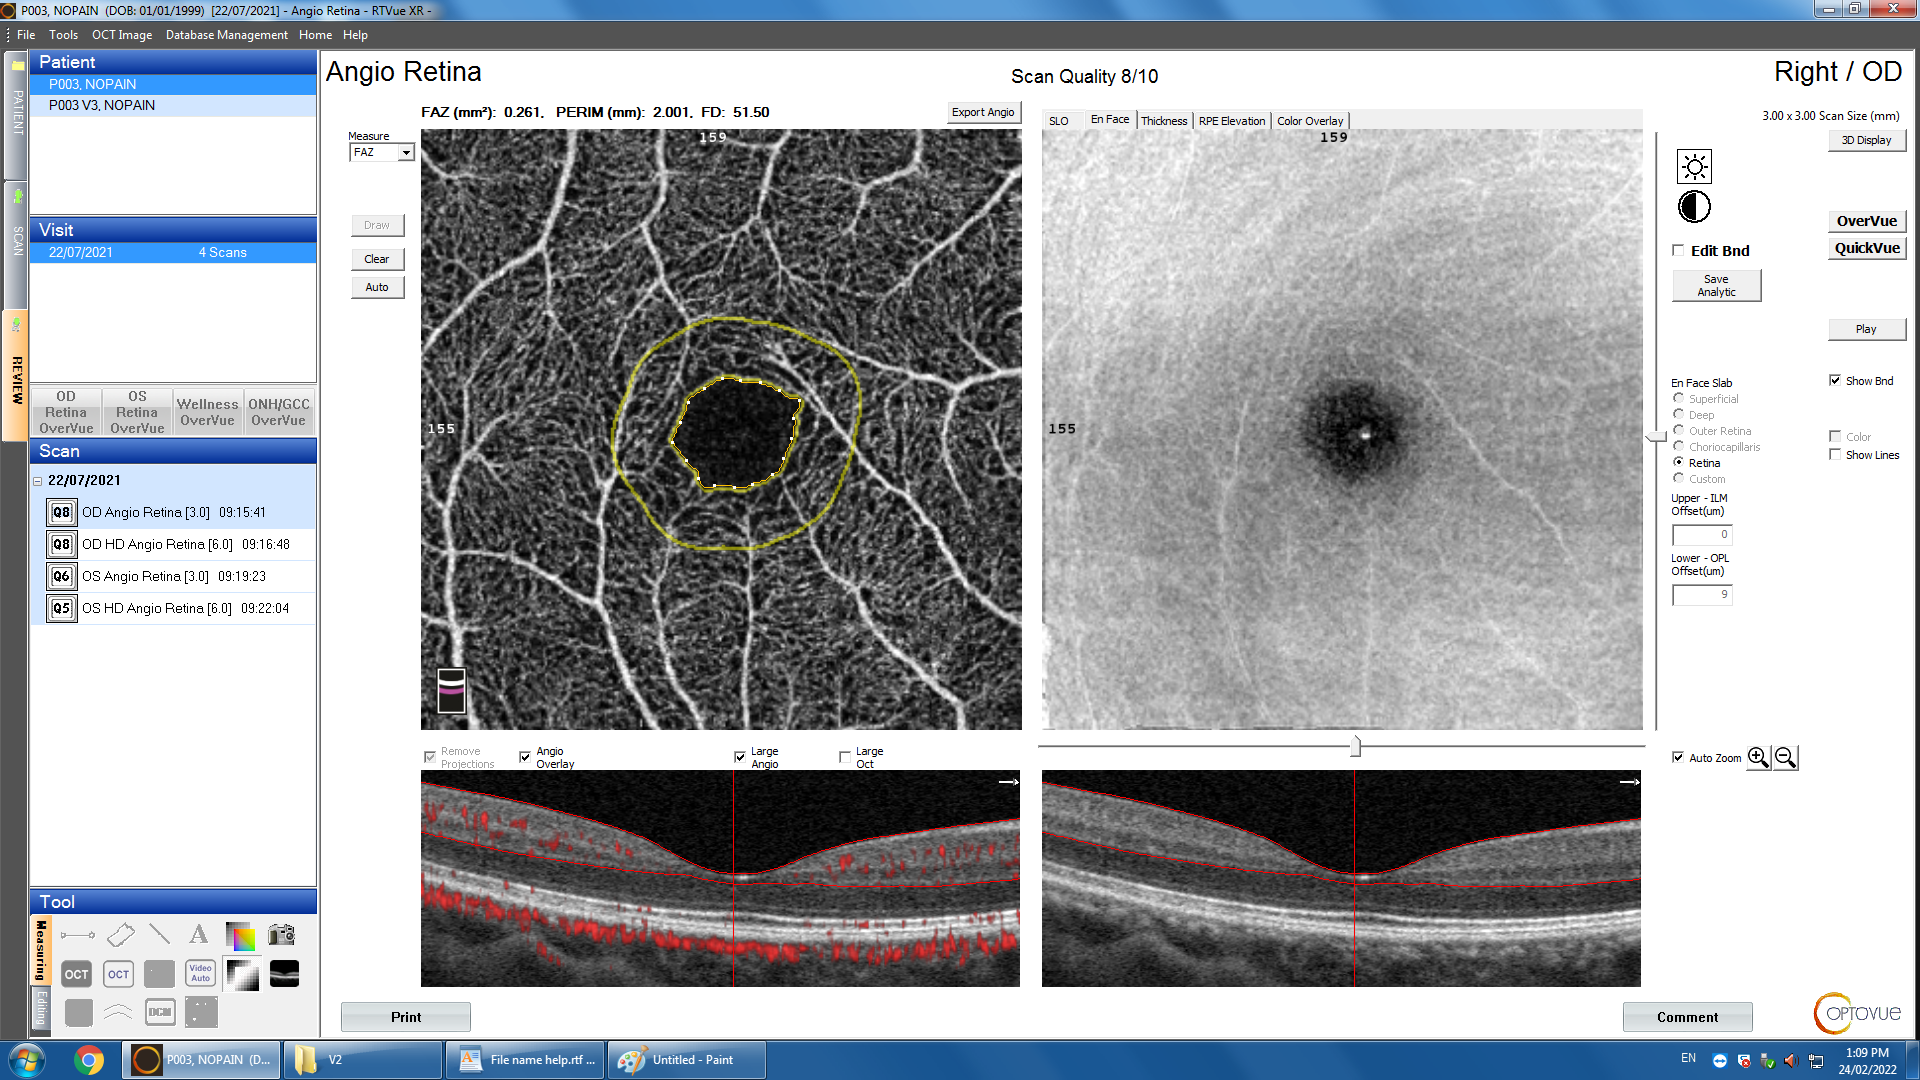

In [72]:
im

# EXCEL

In [ ]:
wb=op.load_workbook('../data/NOPAIN TRIAL OCTA DATA EXTRACTION.xlsx')

In [ ]:
sheet_names=wb.sheetnames
ws=wb.active
ws.cell(,range="A:CS").value

In [ ]:
cols=[]
for i in range(1,98):
    temp=ws.cell(row=3,column=i).value
    if temp not in cols and type(temp) is not int:
        cols.append(temp)
    elif 'grid_v_d'+str(temp) not in cols and type(temp) is int:
        cols.append('grid_v_d'+str(temp))
cols

# Density Images

In [ ]:
# Opens a image in RGB mode
# im = Image.open(r"og_pictures/P001, L eye, V2, 6.0 - Density DP.png")
im = Image.open(r"og_pictures/P001, L eye, V2, 3.0 - Density DP.png")

# Size of the image in pixels (size of original image)
# (This is not mandatory)
width, height = im.size
# Setting the points for cropped imagee
table_top={
    'l' : 1530,
    't' : 154,
    'r' : 1825,
    'b' : 540
    }
table_bot={
    'l' : 1540,
    't' : 565,
    'r' : 1820,
    'b' : 625
    }
quality={
    'l' : 1116,
    't' : 55,
    'r' : 1200,
    'b' : 100
    }

crop_dict=table_top
cropped = im.crop((crop_dict['l'], crop_dict['t'], crop_dict['r'], crop_dict['b']))
cropped.save('evaluate/cropped.png')
ocr=OCR(image_folder="evaluate/")
results=ocr.easyocr_model_works(visualization=False)  

# display(im)
display(cropped)

# Shows the image in image viewer

In [ ]:
cropped.save('evaluate/cropped.png')

In [ ]:
ocr=OCR(image_folder="evaluate/")

if __name__ == "__main__":
#     ocr.keras_ocr_works()  #THIS WORKS TERRIBLY
    results=ocr.easyocr_model_works()  
#     ocr.pytesseract_model_works()




In [ ]:
#TOP
data_lin=np.array(results,dtype=object)[:,1]
data_2d=np.split(data_lin,data_lin.shape[0]/3)
df=pd.DataFrame(data_2d)
df

In [ ]:
#BOT
data_lin=np.array(results,dtype=object)[:,1]
data_2d=np.split(data_lin,data_lin.shape[0]/3)
df=pd.DataFrame(data_2d)
df

# FAZ

In [ ]:
# Opens a image in RGB mode
# im = Image.open(r"og_pictures/P001, L eye, V2, 6.0 - Density DP.png")
im = Image.open(r"og_pictures/P001, L eye, V2, 3.0 - FAZ.png")

# Size of the image in pixels (size of original image)
# (This is not mandatory)
width, height = im.size
# Setting the points for cropped imagee
values={
    'l' : 400,
    't' : 90,
    'r' : 800,
    'b' : 120
    }


quality={
    'l' : 1116,
    't' : 55,
    'r' : 1200,
    'b' : 100
    }

crop_dict=values
cropped = im.crop((crop_dict['l'], crop_dict['t'], crop_dict['r'], crop_dict['b']))
cropped.save('evaluate/cropped.png')
ocr=OCR(image_folder="evaluate/")
results=ocr.easyocr_model_works(visualization=False)  

display(cropped)
# display(im)

# Shows the image in image viewer

In [ ]:
results